<a href="https://colab.research.google.com/github/Dreaming-future/Pytorch-Image-Classification/blob/main/%E8%BF%81%E7%A7%BB%E5%AD%A6%E4%B9%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 加载数据集

In [10]:
!rm -rf cats_and_dogs_filtered
!rm -rf cats_and_dogs_filtered.zip
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -q cats_and_dogs_filtered.zip

--2022-03-15 16:06:01--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 2607:f8b0:4023:c0b::80
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   300MB/s    in 0.2s    

2022-03-15 16:06:01 (300 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [11]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from torchsummary import summary
import numpy as np
import torch.nn as nn
import torchvision.models as models
import os
import time

In [12]:
transform = transforms.Compose([transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 

In [15]:
root = './cats_and_dogs_filtered'
trainset = torchvision.datasets.ImageFolder(root + '/train',transform=transform)
valset = torchvision.datasets.ImageFolder(root + '/validation',transform=transform)

In [16]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True,num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=64,shuffle=False,num_workers=2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [50]:
train_size = len(trainset)
val_size = len(valset)
print(u"训练集个数:", len(trainset))
print(u"验证集个数:", len(valset))

训练集个数: 2000
验证集个数: 1000


In [18]:
trainset

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: ./cats_and_dogs_filtered/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [19]:
trainset.class_to_idx

{'cats': 0, 'dogs': 1}

In [20]:
trainset.classes

['cats', 'dogs']

In [21]:
trainset.imgs[0][0]

'./cats_and_dogs_filtered/train/cats/cat.0.jpg'

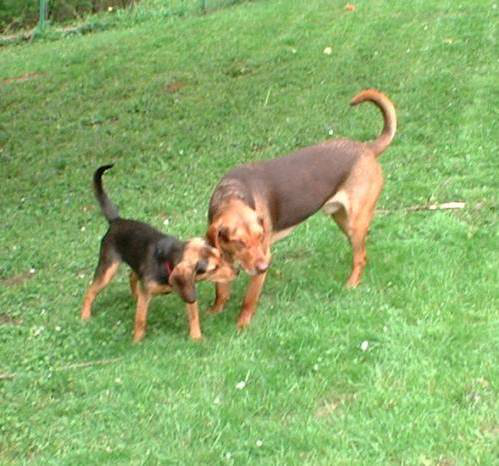

In [23]:
n = np.random.randint(0,train_size)
Image.open(trainset.imgs[n][0])

In [24]:
trainset[0][0].shape

torch.Size([3, 224, 224])

## 迁移学习网络

In [25]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# resnet18 = models.resnet18(pretrained=True)
# alexnet = models.alexnet(pretrained=True)
# squeezenet = models.squeezenet1_0(pretrained=True)
# vgg16 = models.vgg16(pretrained=True)
# densenet = models.densenet161(pretrained=True)
# inception = models.inception_v3(pretrained=True)
# shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
# mobilenet = models.mobilenet_v2(pretrained=True)
# mnasnet = models.mnasnet1_0(pretrained=True)


In [36]:
dir(models)

['AlexNet',
 'DenseNet',
 'EfficientNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'MobileNetV3',
 'RegNet',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'efficientnet',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'feature_extraction',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mobilenetv2',
 'mobilenetv3',
 'quantization',
 'regnet',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 're

### 定义训练模型的函数

In [26]:
def get_acc(outputs, label):
    total = outputs.shape[0]
    probs, pred_y = outputs.data.max(dim=1) # 得到概率
    correct = (pred_y == label).sum().data
    return correct / total

def train(net,path = './model.pth',epoches = 10, writer = None, verbose = False):
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=3,factor=0.5,min_lr=1e-6)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    best_acc = 0
    train_acc_list, val_acc_list = [],[]
    train_loss_list, val_loss_list = [],[]
    lr_list  = []
    for i in range(epoches):
        start = time.time()
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        if torch.cuda.is_available():
            net = net.to(device)
        net.train()
        for step,data in enumerate(trainloader,start=0):
            im,label = data
            im = im.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            # 释放内存
            if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
            # formard
            outputs = net(im)
            loss = criterion(outputs,label)
            # backward
            loss.backward()
            # 更新参数
            optimizer.step()
            train_loss += loss.data
            train_acc += get_acc(outputs,label)
            # 打印下载进度
            rate = (step + 1) / len(trainloader)
            a = "*" * int(rate * 50)
            b = "." * (50 - int(rate * 50))
            print('\r train {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoches,int(rate*100),a,b),end='')
        train_loss = train_loss / len(trainloader)
        train_acc = train_acc * 100 / len(trainloader)
        if verbose:
            train_acc_list.append(train_acc)
            train_loss_list.append(train_loss)
    #     print('train_loss:{:.6f} train_acc:{:3.2f}%' .format(train_loss ,train_acc),end=' ')  
        # 记录学习率
        lr = optimizer.param_groups[0]['lr']
        if verbose:
            lr_list.append(lr)
        # 更新学习率
        scheduler.step(train_loss)

        net.eval()
        with torch.no_grad():
            for step,data in enumerate(valloader,start=0):
                im,label = data
                im = im.to(device)
                label = label.to(device)
                # 释放内存
                if hasattr(torch.cuda, 'empty_cache'):
                    torch.cuda.empty_cache()
                outputs = net(im)
                loss = criterion(outputs,label)
                val_loss += loss.data
                # probs, pred_y = outputs.data.max(dim=1) # 得到概率
                # test_acc += (pred_y==label).sum().item()
                # total += label.size(0)
                val_acc += get_acc(outputs,label)
                rate = (step + 1) / len(valloader)
                a = "*" * int(rate * 50)
                b = "." * (50 - int(rate * 50))
                print('\r test  {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoches,int(rate*100),a,b),end='')
        val_loss = val_loss / len(valloader)
        val_acc = val_acc * 100 / len(valloader)
        if verbose:
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
        end = time.time()
        print(
            '\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}% Val Loss:{:>.6f}  Val Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(
                i + 1, epoches, train_loss, train_acc, val_loss, val_acc,lr), end='')
        
        time_ = int(end - start)
        h = time_ / 3600
        m = time_ % 3600 /60
        s = time_ % 60
        time_str = "\tTime %02d:%02d" % ( m, s)
        # ====================== 使用 tensorboard ==================
        if writer is not None:
            writer.add_scalars('Loss', {'train': train_loss,
                                    'valid': val_loss}, i+1)
            writer.add_scalars('Acc', {'train': train_acc ,
                                   'valid': val_acc}, i+1)
#             writer.add_scalars('Learning Rate',lr,i+1)
        # =========================================================
        # 答应所用时间
        print(time_str)
        # 如果取得更好的准确率，就保存模型
        if val_acc > best_acc:
            torch.save(net,path)
            best_acc = val_acc
    Acc = {}
    Loss = {}
    Acc['train_acc'] = train_acc_list
    Acc['val_acc'] = val_acc_list
    Loss['train_loss'] = train_loss_list
    Loss['val_loss'] = val_loss_list
    Lr = lr_list
    return Acc, Loss, Lr

### 定义一个测试的函数

In [27]:
import matplotlib.pyplot as plt
def test(path, model):
    # 读取要预测的图片
    img = Image.open(path).convert('RGB') # 读取图像

    data_transform = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    class_indict = ["cat", "dog"]
    plt.imshow(img)
    img = data_transform(img)
    img = img.to(device)
    img = torch.unsqueeze(img, dim=0)
    model.eval()
    with torch.no_grad():
        # predict class
        output = torch.squeeze(model(img))
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).data.cpu().numpy()
    print(class_indict[predict_cla], predict[predict_cla].data.cpu().numpy())
    plt.show()

In [28]:
if not os.path.exists('./model/'):
    os.mkdir('./model')

### 1.AlexNet

In [29]:
# 导入Pytorch封装的AlexNet网络模型
alexnet = models.alexnet(pretrained=True)
# 固定卷积层参数
for param in alexnet.parameters():
    param.requires_grad = False
# 获取最后一个全连接层的输入通道数
num_input = alexnet.classifier[6].in_features
# 获取全连接层的网络结构
feature_model = list(alexnet.classifier.children())
# 去掉原来的最后一层
feature_model.pop()
# 添加上适用于自己数据集的全连接层
feature_model.append(nn.Linear(num_input, 2))
# 仿照这里的方法，可以修改网络的结构，不仅可以修改最后一个全连接层
# 还可以为网络添加新的层
# 重新生成网络的后半部分
alexnet.classifier = nn.Sequential(*feature_model)
for param in alexnet.classifier.parameters():
    param.requires_grad = True
alexnet = alexnet.to(device)
#打印一下
print(alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [30]:
summary(alexnet,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [32]:
train(alexnet, "./model/alexnet.pth")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 train   1| 10 84 %  [******************************************->........] 

KeyboardInterrupt: ignored

In [ ]:
n = np.random.randint(0,val_size)
test(root + 'test/%d.jpg'% n ,vgg16)

### 2.VGG16

In [34]:
vgg16 = models.vgg16_bn(pretrained=True)
# 固定模型权重
for param in vgg16.parameters():
    param.requires_grad = False
    
# 最后加一个分类器
vgg16.classifier[6] = nn.Sequential(nn.Linear(4096, 2))
for param in vgg16.classifier[6].parameters():
    param.requires_grad = True
    
vgg16 = vgg16.to(device)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [35]:
summary(vgg16,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
train(vgg16, "./model/vgg16.pth")

Epoch [  1/ 10]  Train Loss:0.071487  Train Acc:97.33% Val Loss:0.047137  Val Acc:98.42%  Learning Rate:0.010000	Time 07:34
Epoch [  2/ 10]  Train Loss:0.057413  Train Acc:97.89% Val Loss:0.037040  Val Acc:98.75%  Learning Rate:0.010000	Time 06:49
Epoch [  3/ 10]  Train Loss:0.056943  Train Acc:97.99% Val Loss:0.040015  Val Acc:98.56%  Learning Rate:0.010000	Time 06:45
Epoch [  4/ 10]  Train Loss:0.056988  Train Acc:97.90% Val Loss:0.044927  Val Acc:98.42%  Learning Rate:0.010000	Time 06:44
Epoch [  5/ 10]  Train Loss:0.058226  Train Acc:97.89% Val Loss:0.040388  Val Acc:98.54%  Learning Rate:0.010000	Time 06:45
Epoch [  6/ 10]  Train Loss:0.053336  Train Acc:98.06% Val Loss:0.040575  Val Acc:98.58%  Learning Rate:0.010000	Time 06:53
Epoch [  7/ 10]  Train Loss:0.056317  Train Acc:97.95% Val Loss:0.043550  Val Acc:98.52%  Learning Rate:0.010000	Time 07:08
Epoch [  8/ 10]  Train Loss:0.056145  Train Acc:97.96% Val Loss:0.038649  Val Acc:98.66%  Learning Rate:0.010000	Time 06:58
Epoch [ 

({'train_acc': [], 'val_acc': []}, {'train_loss': [], 'val_loss': []}, [])

cat 1.0


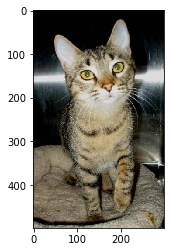

In [ ]:
n = np.random.randint(0,val_size)
test(root + 'test/%d.jpg'% n ,vgg16)

### 3.ResNet18

In [ ]:
resnet18 = models.resnet18(pretrained=True)

for param in resnet18.parameters():
    param.requires_grad = False
    
inchannel = resnet18.fc.in_features
resnet18.fc = nn.Linear(inchannel, 2)
for param in resnet18.fc.parameters():
    param.requires_grad = True
    
resnet18 = resnet18.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\86137/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth


In [ ]:
summary(resnet18,(3,224,224))

In [ ]:
train(resnet18, "./model/resnet18.pth")

Epoch [  1/ 10]  Train Loss:0.092101  Train Acc:96.34% Val Loss:0.058147  Val Acc:97.77%  Learning Rate:0.010000	Time 05:21
Epoch [  2/ 10]  Train Loss:0.083978  Train Acc:96.88% Val Loss:0.081815  Val Acc:97.09%  Learning Rate:0.010000	Time 04:40
Epoch [  3/ 10]  Train Loss:0.075946  Train Acc:97.08% Val Loss:0.063055  Val Acc:97.77%  Learning Rate:0.010000	Time 04:57
Epoch [  4/ 10]  Train Loss:0.072917  Train Acc:97.34% Val Loss:0.055050  Val Acc:98.18%  Learning Rate:0.010000	Time 05:54
Epoch [  5/ 10]  Train Loss:0.064799  Train Acc:97.59% Val Loss:0.056419  Val Acc:98.02%  Learning Rate:0.010000	Time 04:41
Epoch [  6/ 10]  Train Loss:0.061354  Train Acc:97.68% Val Loss:0.054933  Val Acc:98.10%  Learning Rate:0.010000	Time 04:29
Epoch [  7/ 10]  Train Loss:0.071761  Train Acc:97.54% Val Loss:0.065232  Val Acc:97.55%  Learning Rate:0.010000	Time 04:04
Epoch [  8/ 10]  Train Loss:0.065548  Train Acc:97.57% Val Loss:0.052685  Val Acc:98.30%  Learning Rate:0.010000	Time 04:29
Epoch [ 

({'train_acc': [], 'val_acc': []}, {'train_loss': [], 'val_loss': []}, [])

dog 1.0


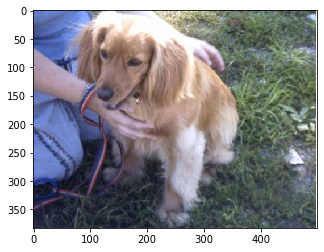

In [ ]:
n = np.random.randint(0,val_size)
test(root + 'test/%d.jpg'% n ,resnet18)

### 4.DenseNet

In [ ]:
densenet121 = models.densenet121(pretrained=True)

for param in densenet121.parameters():
    param.requires_grad = False
    
inchannel = densenet121.classifier.in_features
densenet121.classifier = nn.Linear(inchannel, 2)
for param in densenet121.classifier.parameters():
    param.requires_grad = True
    
densenet121 = densenet121.to(device)

In [ ]:
summary(densenet121,(3,224,224))

In [ ]:
train(densenet121,"./model/densenet121.pth",epoches=20,writer=writer)

Epoch [  1/ 50]  Train Loss:0.069421  Train Acc:97.06% Val Loss:0.045408  Val Acc:98.50%  Learning Rate:0.010000	Time 04:12
Epoch [  2/ 50]  Train Loss:0.055100  Train Acc:97.94% Val Loss:0.045141  Val Acc:98.60%  Learning Rate:0.010000	Time 03:50
Epoch [  3/ 50]  Train Loss:0.048683  Train Acc:98.20% Val Loss:0.046111  Val Acc:98.36%  Learning Rate:0.010000	Time 04:07
Epoch [  4/ 50]  Train Loss:0.047130  Train Acc:98.17% Val Loss:0.039344  Val Acc:98.67%  Learning Rate:0.010000	Time 04:03
Epoch [  5/ 50]  Train Loss:0.048824  Train Acc:98.09% Val Loss:0.047738  Val Acc:98.58%  Learning Rate:0.010000	Time 03:29
Epoch [  6/ 50]  Train Loss:0.051442  Train Acc:98.11% Val Loss:0.044026  Val Acc:98.58%  Learning Rate:0.010000	Time 03:37
Epoch [  7/ 50]  Train Loss:0.042843  Train Acc:98.42% Val Loss:0.057952  Val Acc:97.96%  Learning Rate:0.010000	Time 04:08
Epoch [  8/ 50]  Train Loss:0.049442  Train Acc:98.26% Val Loss:0.054428  Val Acc:98.28%  Learning Rate:0.010000	Time 03:31
Epoch [ 

({'train_acc': [], 'val_acc': []}, {'train_loss': [], 'val_loss': []}, [])

dog 0.9999974


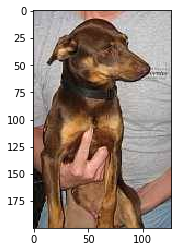

In [ ]:
n = np.random.randint(0,val_size)
test(root + 'test/%d.jpg'% n ,densenet121)

### 5.MobileNet V2

In [44]:
mobilenet = models.mobilenet_v2(pretrained=True)

for param in mobilenet.parameters():
    param.requires_grad = False
    
# 最后加一个分类器
mobilenet.classifier[1] = nn.Sequential(nn.Linear(1280, 2))
for param in mobilenet.classifier[1].parameters():
    param.requires_grad = True
    
mobilenet = mobilenet.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [45]:
mobilenet

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [ ]:
summary(mobilenet,(3,224,224))

In [ ]:
train(mobilenet,"./model/mobilenet.pth")

Epoch [  1/ 10]  Train Loss:0.092556  Train Acc:96.13% Val Loss:0.056114  Val Acc:98.00%  Learning Rate:0.010000	Time 02:55
Epoch [  2/ 10]  Train Loss:0.073321  Train Acc:97.14% Val Loss:0.052979  Val Acc:98.18%  Learning Rate:0.010000	Time 02:06
Epoch [  3/ 10]  Train Loss:0.075686  Train Acc:97.23% Val Loss:0.060839  Val Acc:97.78%  Learning Rate:0.010000	Time 01:57
Epoch [  4/ 10]  Train Loss:0.079644  Train Acc:96.93% Val Loss:0.073229  Val Acc:97.53%  Learning Rate:0.010000	Time 01:59
Epoch [  5/ 10]  Train Loss:0.081197  Train Acc:96.96% Val Loss:0.052441  Val Acc:98.20%  Learning Rate:0.010000	Time 01:58
Epoch [  6/ 10]  Train Loss:0.072206  Train Acc:97.19% Val Loss:0.052156  Val Acc:98.10%  Learning Rate:0.010000	Time 02:01
Epoch [  7/ 10]  Train Loss:0.074642  Train Acc:97.15% Val Loss:0.053458  Val Acc:98.04%  Learning Rate:0.010000	Time 03:22
Epoch [  8/ 10]  Train Loss:0.072543  Train Acc:97.33% Val Loss:0.060096  Val Acc:97.92%  Learning Rate:0.010000	Time 02:07
Epoch [ 

({'train_acc': [], 'val_acc': []}, {'train_loss': [], 'val_loss': []}, [])

dog 0.99671364


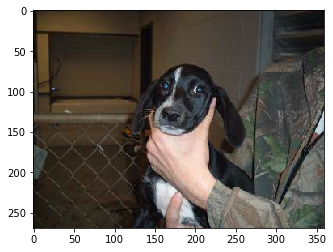

In [ ]:
n = np.random.randint(0,val_size)
test(root + 'test/%d.jpg'% n ,mobilenet)

### 6.ShuffleNetV2

In [42]:
shufflenet = models.shufflenet_v2_x1_0(pretrained=True)

for param in shufflenet.parameters():
    param.requires_grad = False
    
# 最后加一个分类器
inchannel = shufflenet.fc.in_features
shufflenet.fc = nn.Linear(inchannel, 2)
for param in shufflenet.fc.parameters():
    param.requires_grad = True
    
shufflenet = shufflenet.to(device)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


  0%|          | 0.00/8.79M [00:00<?, ?B/s]

NameError: ignored

In [ ]:
summary(shufflenet,(3,224,224))

In [ ]:
train(shufflenet,"./model/shufflenet.pth")

Epoch [  1/ 10]  Train Loss:0.407648  Train Acc:88.84% Val Loss:0.096014  Val Acc:97.61%  Learning Rate:0.010000	Time 03:10
Epoch [  2/ 10]  Train Loss:0.068225  Train Acc:97.93% Val Loss:0.050991  Val Acc:98.38%  Learning Rate:0.010000	Time 02:18
Epoch [  3/ 10]  Train Loss:0.034774  Train Acc:98.88% Val Loss:0.044972  Val Acc:98.46%  Learning Rate:0.010000	Time 02:37
Epoch [  4/ 10]  Train Loss:0.020964  Train Acc:99.38% Val Loss:0.045224  Val Acc:98.32%  Learning Rate:0.010000	Time 02:22
Epoch [  5/ 10]  Train Loss:0.017840  Train Acc:99.42% Val Loss:0.044285  Val Acc:98.48%  Learning Rate:0.010000	Time 02:21
Epoch [  6/ 10]  Train Loss:0.011427  Train Acc:99.66% Val Loss:0.042665  Val Acc:98.58%  Learning Rate:0.010000	Time 02:22
Epoch [  7/ 10]  Train Loss:0.008015  Train Acc:99.80% Val Loss:0.048528  Val Acc:98.32%  Learning Rate:0.010000	Time 02:59
Epoch [  8/ 10]  Train Loss:0.008493  Train Acc:99.79% Val Loss:0.042361  Val Acc:98.64%  Learning Rate:0.010000	Time 03:44
Epoch [ 

({'train_acc': [], 'val_acc': []}, {'train_loss': [], 'val_loss': []}, [])

dog 0.9999373


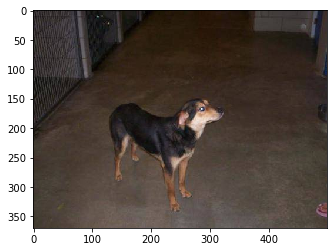

In [ ]:
n = np.random.randint(0,val_size)
test(root + 'test/%d.jpg'% n ,shufflenet)

### 7.Mnasnet

In [41]:
mnasnet.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [46]:
mnasnet = models.mnasnet1_0(pretrained=True)
for param in mnasnet.parameters():
    param.requires_grad = False
    
# 最后加一个分类器
mnasnet.classifier[1] = nn.Sequential(nn.Dropout(p=0.2),nn.Linear(1280, 2))
for param in mnasnet.classifier[1].parameters():
    param.requires_grad = True
    
mnasnet = mnasnet.to(device)

In [47]:
summary(mnasnet,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
            Conv2d-9         [-1, 48, 112, 112]             768
      BatchNorm2d-10         [-1, 48, 112, 112]              96
             ReLU-11         [-1, 48, 112, 112]               0
           Conv2d-12           [-1, 48, 56, 56]             432
      BatchNorm2d-13           [-1, 48, 56, 56]              96
             ReLU-14           [-1, 48,

In [48]:
train(mnasnet,"./model/mnasnet.pth")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 train   1| 10  9 %  [****->..............................................] 

KeyboardInterrupt: ignored

In [ ]:
n = np.random.randint(0,val_size)
test(root + 'test/%d.jpg'% n ,mnasnet)

## 总结

前面分别使用了Alexnet、VGGNet、ResNet、DenseNet、MobileNet、ShuffleNet 六种网络结构来试验迁移学习，发现效果其实是都差不多都在94%左右。
**注**：这里并没有使用Inception网络结构，因为他的图片输入大小为（299,299），且他的网络输出结果有三个值，所以对应训练过程的损失也有三部分：
```
images, labels = data
optimizer.zero_grad()
logits, aux_logits2, aux_logits1 = net(images.to(device))
loss0 = loss_function(logits, labels.to(device))
loss1 = loss_function(aux_logits1, labels.to(device))
loss2 = loss_function(aux_logits2, labels.to(device))
loss = loss0 + loss1 * 0.3 + loss2 * 0.3
loss.backward()
optimizer.step()
```
总的来说迁移学习优点真的是太好了，速度快，准确率高，而且还不用担心GPU内存不够，CPU都能给你跑。

In [ ]:
# import torch.nn as nn
# from torchvision import datasets, models

# # 你要分类的种类数
# num_classes = 2

# # 训练的批量大小（根据您拥有的内存量而变化）
# BATCH_SIZE = 128

# # 用于特征提取的标志。当为False时，我们会微调整个模型；当为True时，我们只会更新重塑的图层参数
# feature_extract = True

# #是否改变卷及层的参数
# def set_parameter_requires_grad(model, feature_extracting):
#     if feature_extracting:
#         for param in model.parameters():
#             param.requires_grad = False

# def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
#         # 初始化这些变量，这些变量将在此if语句中设置。这些变量中的每一个都是特定于模型的。
#         model_ft = None
#         input_size = 0

#     if model_name == "resnet":
#         """ Resnet18
#         """
#         model_ft = models.resnet18(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
#         num_ftrs = model_ft.fc.in_features
#         model_ft.fc = nn.Linear(num_ftrs, num_classes)
#         input_size = 224

#     elif model_name == "alexnet":
#         """ Alexnet
#         """
#         model_ft = models.alexnet(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
#         num_ftrs = model_ft.classifier[6].in_features
#         model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
#         input_size = 224

#     elif model_name == "vgg":
#         """ VGG16_bn
#         """
#         model_ft = models.vgg16_bn(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
#         num_ftrs = model_ft.classifier[6].in_features
#         model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
#         input_size = 224

#     elif model_name == "squeezenet":
#         """ Squeezenet
#         """
#         model_ft = models.squeezenet1_0(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
#         model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
#         model_ft.num_classes = num_classes
#         input_size = 224

#     elif model_name == "densenet":
#         """ Densenet
#         """
#         model_ft = models.densenet121(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
#         num_ftrs = model_ft.classifier.in_features
#         model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
#         input_size = 224
                
#     elif model_name == "shufflenet":
#         """ShuffleNetV2
#         """
#         model_ft = models.shufflenet_v2_x1_0(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
#         num_ftrs = model_ft.fc.in_features
#         model_ft.fc = nn.Linear(num_ftrs, num_classes)
#         input_size = 224

#     elif model_name == "mobilenet":
#         """ MobileNet V2 
#         """
#         model_ft = models.mobilenet_v2(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
#         num_ftrs = model_ft.classifier[1].in_features
#         model_ft.classifier[1] = nn.Linear(num_ftrs,num_classes)
#         input_size = 224
        
#     else:
#         print("Invalid model name, exiting...")
#         exit()
    
#     return model_ft, input_size

# # Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
# model_name = "vgg"#调用模型的名字
# # Initialize the model for this run
# model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# # Print the model we just instantiated
# #print(model_ft, input_size)



In [ ]:
import pandas as pd
def test_all(model,path):
    result = []
    for i in range(1,val_size+1):
        path = root + 'test/%d.jpg'%(i)
        img = Image.open(path).convert('RGB') # 读取图像

        data_transform = transforms.Compose([transforms.Resize(256),
                          transforms.CenterCrop(224),
                          transforms.ToTensor(),
                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        class_indict = ["cat", "dog"]
        img = data_transform(img)
        img = img.to(device)
        img = torch.unsqueeze(img, dim=0)
        model.eval()
        with torch.no_grad():
            # predict class
            output = torch.squeeze(model(img))
            predict = torch.softmax(output, dim=0)
            predict_cla = torch.argmax(predict).data.cpu().numpy()
        result.append(predict_cla.item())
        if i % 500 == 0:
            print(str(i) + ' jpgs' + ' success')
    submission_df = pd.DataFrame({'id':range(1,1+val_size), 'label':result})
    submission_df.to_csv(path,index=False)
    print('保存成功')

In [31]:
test_all(densenet121,'denset_submission.csv')

NameError: ignored